# Multi-Layer Perceptron Neural Network

In this assignment, We will construct and train a multi-layer perceptron (MLP) model to categorize pictures into 10 classes.
## Background

![mlp](./mlp.png)

An Multi-Layer Perceptron (MLP) is a classic type of feedforward artificial neural network (ANN). 
It serves as the foundation for many more complex deep learning architectures.
An MLP is structured in a series of layers:
- Input Layer: This is where the network receives your raw data or features.
- Hidden Layer(s): One or more layers of neurons (or nodes) positioned between the input and output. 
This is where the "learning" and complex computation primarily occur. 
A network with multiple hidden layers is what makes it "deep."
- Output Layer: This final layer produces the network's prediction, such as a class probability or a continuous value.

In an MLP, each neuron in one layer is typically fully connected to every neuron in the next. 
The power of the MLP comes from its non-linear activation functions (like ReLU or sigmoid) applied within the hidden neurons. 
These functions allow the network to learn and model complex, non-linear patterns in data. 

MLP itself has a wide an a variety of applications (e.g. image classification, fraud detection, spam filtering, etc..).
It also serves as key components in today's larger scale AI models such as in Convolutional Neural Network (CNN), Deep Reinforcement Learning (DRL), Large Language Model (LLM), etc..
  
## Objectives:
- Review data preprocessing techniques (rescale, flatten, one-hot encoding, etc.).
- Practice MLP construction with arbitrary hidden layer dimensions.
- Realize a variety of activation functions (`sigmoid`, `tanh`, `relu`, `leaky_relu`).
- Realize the special softmax activation which formats features into categorical probability distributions.
- Ultilize cross entropy function to evaluate a general classification model.  
- Apply back propagation to a multi-layer gradients computation.  
- Reinforce the of model training process.

## Exercises:
<font color=582c83>

1. (10\%) Data Preprocessing
2. (5\%) Parameter Initialization
3. (15\%) Linear Model and Activations
4. (5\%) Cross Entropy Loss
5. (30\%) Gradient Computation
6. (20\%) Gradient Descent Optimization
7. (15\%) Accuracy Evaluation

</font>


## 1. Prepare Data
Torchvision provides a descent pool of datasets. We'll load one of the built-in dataset, [CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html) to investigate a multi-class classification problem.


Number of training samples: 50000
Number of validation samples: 10000
Features shape: (3072,)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


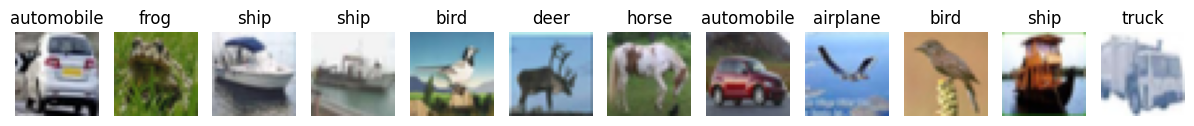

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import Compose, ToImage, ToDtype
import numpy as np
import matplotlib.pyplot as plt

# Construct pre-processing pipeline
feature_transform_pipeline = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    torch.flatten,
    torch.Tensor.numpy,
])
label_transform_pipeline = Compose([
    lambda x:torch.tensor([x]),
    lambda x:torch.nn.functional.one_hot(x,10),
    torch.squeeze,
    torch.Tensor.numpy,
])

# Download datasets
dataset_train = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=feature_transform_pipeline,
    target_transform = label_transform_pipeline,
)

dataset_val = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=feature_transform_pipeline,
    target_transform = label_transform_pipeline,
)
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_val)}")
print(f"Features shape: {dataset_train[0][0].shape}")
print(f"Classes: {dataset_train.classes}")

# Create dataloaders
batch_size = 128
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


# Visualize data samples
sample_batch_train = next(iter(dataloader_train))
fig, axs = plt.subplots(1, 12, figsize=(12, 4))
for i in range(12):
    sample_img = np.transpose(sample_batch_train[0][i].numpy().reshape(3, 32, 32), (1, 2, 0))  # reconstruct image to (H, W, C) format
    sample_cls = dataset_train.classes[sample_batch_train[1][i].numpy().argmax()]
    axs[i] = plt.subplot(1, 12, i + 1)
    axs[i].set_title(sample_cls)
    axs[i].axis('off')
    axs[i].imshow(sample_img)  # image is already in (H, W, C) format
plt.tight_layout()

## 2. Construct Multi-Layer Perceptron Model
A Multi-Layer Perceptron (MLP) model is featured with multiple layers of features, $\mathbf{X}^{[l]}$ s and $\mathbf{Z}^{[l]}$ s. 
The features of the previous layers, ${[l-1]}$ will be transformed (by a stack of a linear function and a non-linear function) to the features in the next layer, ${[l]} \text{, where } l \in {1, 2, \dots, L}$. 

$$
\mathbf{X}^{[l]} = a(\mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]})
$$

The input layer can be defined as $\mathbf{X}^{[0]}$, and the output layer can be defined as $\hat{\mathbf{Y}} = \mathbf{X}^{[L]}$, where $L$ is the index of the last layer.

### 2.1. Initialize Parameters
An MLP model is governed by $L$ sets of $\mathbf{W}^{[l]}$ s and $\mathbf{b}^{[l]}$ s.
Assume $\mathbf{X}^{[l-1]}$ has $N_{l-1}$ features and $\mathbf{X}^{[l]}$ has $N_{l}$ features, $\mathbf{W}^{[l]}$ needs to be an array/matrix with shape $(N_l, N_{l-1})$, and $\mathbf{b}^{[l]}$ needs to be an array/vector with shape $(1, N_l)$.


### <font color=#582c83> Exercise 1: Parameters Initialization </font>
Define a function to initialize weights and biases parameters and save these parameters in a Python **dictionary**. 


In [3]:
def init_params(in_dims: int, hidden_dims: tuple, out_dims: int) -> dict:
    """
    Initialize the parameters of the MLP model.
    Args:
        in_dims: number of input dimensions.
        hidden_dims: tuple/list of hidden layer dimensions.
        out_dims: number of output dimensions.
    Returns:
        params: dictionary containing the initialized weights and biases.
    """
    layer_dims = (in_dims, *hidden_dims, out_dims)
    params = {}
    for l in range(len(layer_dims) - 1):
        params[f'W{l+1}'] = np.random.normal(loc=0, scale=0.1, size=(layer_dims[l + 1], layer_dims[l]))
        params[f'b{l+1}'] = np.random.normal(loc=0, scale=0.0001, size=(1, layer_dims[l + 1]))
    return params

# Example usage
np.random.seed(3321)  # for reproducibility
params_dummy = init_params(in_dims=sample_batch_train[0].numpy().shape[1], hidden_dims=(4, 3), out_dims=sample_batch_train[1].numpy().shape[1])
print(f"Dummy parameter: {params_dummy}")
for key in params_dummy:
    print(f"{key} shape: {params_dummy[key].shape}")


Dummy parameter: {'W1': array([[ 0.0368456 , -0.13878264, -0.0723142 , ...,  0.01476262,
        -0.10967347, -0.18631236],
       [ 0.0626109 , -0.11664279,  0.00737831, ..., -0.05391995,
        -0.00214825,  0.03616649],
       [-0.0892149 , -0.1090383 ,  0.00528383, ..., -0.10592102,
         0.15261464, -0.05313855],
       [ 0.11090477, -0.09542226,  0.22831787, ..., -0.11418551,
        -0.06934532, -0.22189655]], shape=(4, 3072)), 'b1': array([[ 1.04294659e-04, -5.35403148e-05,  1.14698968e-04,
         1.85000344e-04]]), 'W2': array([[-0.05080986,  0.1046614 ,  0.14066771,  0.00291042],
       [ 0.11845765, -0.04425832, -0.11718765, -0.03634791],
       [-0.09860422,  0.01093978, -0.07160529,  0.05205904]]), 'b2': array([[-1.30894305e-04, -8.39531783e-05, -9.25686401e-05]]), 'W3': array([[-0.15204258, -0.08445182,  0.1476833 ],
       [-0.07196692, -0.07523497, -0.03315568],
       [ 0.11689522,  0.111967  ,  0.02795843],
       [-0.02053044, -0.11351672,  0.04676231],
       

**Expected Output**:
>
```console
{'W1': array([[ 0.0368456 , -0.13878264, -0.0723142 , ...,  0.01476262,
        -0.10967347, -0.18631236],
       [ 0.0626109 , -0.11664279,  0.00737831, ..., -0.05391995,
        -0.00214825,  0.03616649],
       [-0.0892149 , -0.1090383 ,  0.00528383, ..., -0.10592102,
         0.15261464, -0.05313855],
       [ 0.11090477, -0.09542226,  0.22831787, ..., -0.11418551,
        -0.06934532, -0.22189655]], shape=(4, 3072)), 'b1': array([[ 1.04294659e-04, -5.35403148e-05,  1.14698968e-04,
         1.85000344e-04]]), 'W2': array([[-0.05080986,  0.1046614 ,  0.14066771,  0.00291042],
       [ 0.11845765, -0.04425832, -0.11718765, -0.03634791],
       [-0.09860422,  0.01093978, -0.07160529,  0.05205904]]), 'b2': array([[-1.30894305e-04, -8.39531783e-05, -9.25686401e-05]]), 'W3': array([[-0.15204258, -0.08445182,  0.1476833 ],
       [-0.07196692, -0.07523497, -0.03315568],
       [ 0.11689522,  0.111967  ,  0.02795843],
       [-0.02053044, -0.11351672,  0.04676231],
       [ 0.09881951,  0.06431384, -0.11860699],
       [ 0.00803933, -0.22014142,  0.12180135],
       [-0.13652621, -0.1537195 ,  0.06154869],
       [ 0.10395008,  0.03099951, -0.14420826],
       [ 0.09003759,  0.08182519, -0.0092451 ],
       [ 0.19018528,  0.03363918, -0.08740904]]), 'b3': array([[ 1.27958953e-04,  3.61149398e-05, -9.17852105e-05,
         1.05089716e-05,  2.14611004e-04,  4.75264495e-06,
        -2.10323449e-05, -5.12094207e-05, -4.22673712e-05,
         8.11998844e-05]])}
W1 shape: (4, 3072)
b1 shape: (1, 4)
W2 shape: (3, 4)
b2 shape: (1, 3)
W3 shape: (10, 3)
b3 shape: (1, 10)
```

### 2.2 - Activate Features
A non-linear activation function will be applied on $\mathbf{Z}^{[l]}$ to form new features $\mathbf{X}^{[l]}$ as the $l$-th layer in an MLP model.
Commonly use activations are:

- Sigmoid
$$x = \sigma (z) = \frac{1}{1 + e^{-z}}$$

- Hyperbolic Tangent
$$x = \tanh (z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

- Rectified Linear Unit
$$
x = ReLU(z) = 
    \begin{cases}
        0   & z \leq 0 \\
        z   & z > 0
    \end{cases}
$$

- Leaky ReLU
$$
x = LeakyReLU(z; a \geq 0) = 
    \begin{cases}
        az   & z \leq 0 \\
        z   & z > 0
    \end{cases}
$$

- Softmax
For a multi-class classification problem, we will want to encode $\mathbf{Z}^{[L]}$ into probability distributions.

$$\hat{\mathbf{y}}_i = \frac{e^{\mathbf{z}^{[L]}_i}}{\sum^C_{i=1} e^{\mathbf{z}^{[L]}_i}}$$

The maxtrix $\mathbf{Z}^{[L]}$ has shape: $(M, C)$, where $M$ is the number of samples, $C$ is the number of classes. 
When applying softmax activation, we only want it to deal with each row of $\mathbf{Z}^{[L]}$, or perform it on the last dimension (axis) of $\mathbf{Z}^{[L]}$.

### <font color=#582c83> Exercise 2. Activations Functions </font>



In [4]:
### START CODE HERE ### (≈ 9 lines of code)
def sigmoid(z):
    """ Sigmoid function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return 1 / (1 + np.exp(-z))


def tanh(z):
    """ Hyperbolic Tangent function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def relu(z):
    """ ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return np.maximum(0, z)


def leaky_relu(z, a=0.05):
    """ Leaky ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
        a: constant, a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return np.maximum(a * z, z)


def softmax(z):
    """ Softmax function
    Args:
        z: independent variable, 2d array with shape (# samples, # features)
    Returns:
        probabilities: dependent variable, 2d array with shape (# samples, # features)
    """
    probabilities = np.exp(z) / np.sum(np.exp(z), axis=-1, keepdims=True)
    return probabilities

# Sanity check
z_dummy = np.linspace(-2, 2, 10).reshape(2, 5)
print(f"Input = \n{z_dummy}")
print(f"Sigmoid activation = \n{sigmoid(z_dummy)}")
print(f"Hyper Tangent activation = \n{tanh(z_dummy)}")
print(f"ReLU activation = \n{relu(z_dummy)}")
print(f"Leaky ReLU activation = \n{leaky_relu(z_dummy, a=0.1)}")
print(f"Softmax activation = \n{softmax(z_dummy)}")



Input = 
[[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Sigmoid activation = 
[[0.11920292 0.17428532 0.2476638  0.33924363 0.44467194]
 [0.55532806 0.66075637 0.7523362  0.82571468 0.88079708]]
Hyper Tangent activation = 
[[-0.96402758 -0.9146975  -0.8044548  -0.58278295 -0.21863508]
 [ 0.21863508  0.58278295  0.8044548   0.9146975   0.96402758]]
ReLU activation = 
[[0.         0.         0.         0.         0.        ]
 [0.22222222 0.66666667 1.11111111 1.55555556 2.        ]]
Leaky ReLU activation = 
[[-0.2        -0.15555556 -0.11111111 -0.06666667 -0.02222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Softmax activation = 
[[0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]
 [0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]]


**Expected Output**:
>
```console
Input = 
[[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Sigmoid activation = 
[[0.11920292 0.17428532 0.2476638  0.33924363 0.44467194]
 [0.55532806 0.66075637 0.7523362  0.82571468 0.88079708]]
Hyper Tangent activation = 
[[-0.96402758 -0.9146975  -0.8044548  -0.58278295 -0.21863508]
 [ 0.21863508  0.58278295  0.8044548   0.9146975   0.96402758]]
ReLU activation = 
[[0.         0.         0.         0.         0.        ]
 [0.22222222 0.66666667 1.11111111 1.55555556 2.        ]]
Leaky ReLU activation = 
[[-0.2        -0.15555556 -0.11111111 -0.06666667 -0.02222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Softmax activation = 
[[0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]
 [0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]]
```

### 2.3. Forward Propagation
The forward pass of an MLP model is looping the linear and activation transforms. 

### <font color=#582c83> Exercise 3. MLP Model Construction </font>


In [ ]:
def linear(in_features, weights, biases):
    """ Linear function
    Args:
        in_features: input feature matrix, 2d array with shape (# samples, # input features)
        weights: weight parameter matrix, 2d array with shape (# next layer features , # input features)
        biases: bias parameter vector, 2d array with shape (1, # next layer features)
    Returns:
        linear_output: linear model output feature matrix, 2d array with shape (# samples, # next layer features)
    """
    linear_output = in_features @ weights.T + biases
    return linear_output

def forward(in_features, params, hidden_activation=None, out_activation=None):
    """ Forward function
    Args:
        in_features: feature matrix, 2d array with shape (# samples, # pixels)
        params: a dictionary of weights and biases
            params = {
                'W1': weight matrix of the first layer, 2d array with shape (# hidden features in 1st layer, # input features)
                'b1': bias vector of the first layer, 2d array with shape (1, # hidden features in 1st layer)
                ...
                'Wi': weight matrix of the i-th layer, 2d array with shape (# hidden features in i-th layer, # hidden features in (i-1)-th layer)
                'bi': bias vector of the i-th layer, 2d array with shape (1, # hidden features in i-th layer)
                ...
                'WL': weight matrix of the last layer, 2d array with shape (# hidden features in output layer, # hidden features in (L-1)-th layer)
                'bL': bias vector of the last layer, 2d array with shape (1, # output features)
            }
        hidden_activation: activation function for hidden layers, could be sigmoid, relu, etc. If None, no activation is applied.
        out_activation: activation function for output layer, could be sigmoid, softmax, etc. If None, no activation is applied.
    Returns:
        predictions: predicted probabilities, a column vector or 2d array with shape (# samples, # output features)
        cache: linear activated features
    """

    num_layers = len(params) // 2
    # Input layer
    cache = {'X0': in_features}
    # Hidden layers
    for i in range(num_layers - 1):
        cache[f'Z{i+1}'] = linear(cache[f'X{i}'], params[f'W{i+1}'], params[f'b{i+1}'])
        if hidden_activation=="relu":
            cache[f'X{i+1}'] = relu(cache[f'Z{i+1}'])
        elif hidden_activation=="leaky_relu":
            cache[f'X{i+1}'] = leaky_relu(cache[f'Z{i+1}'])
        elif hidden_activation=="sigmoid":
            cache[f'X{i+1}'] = sigmoid(cache[f'Z{i+1}'])
        elif hidden_activation=="tanh":
            cache[f'X{i+1}'] = tanh(cache[f'Z{i+1}'])
        else:
            cache[f'X{i+1}'] = cache[f'Z{i+1}']
    # Output layer
    cache[f'Z{num_layers}'] = linear(cache[f'X{num_layers-1}'], params[f'W{num_layers}'], params[f'b{num_layers}'])
    if out_activation=="relu":
        predictions = relu(cache[f'Z{num_layers}'])
    elif out_activation=="leaky_relu":
        predictions = leaky_relu(cache[f'Z{num_layers}'])
    elif out_activation=="sigmoid":
        predictions = sigmoid(cache[f'Z{num_layers}'])
    elif out_activation=="tanh":
        predictions = tanh(cache[f'Z{num_layers}'])
    elif out_activation=="softmax":
        predictions = softmax(cache[f'Z{num_layers}'])
    else:
        predictions = cache[f'Z{num_layers}']
    return predictions, cache

# Sanity check
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "sigmoid", "softmax")
print(f"Features: {list(cache_dummy.keys())[:]}")
print(f"Shape of dummy predictions: {preds_dummy.shape}")
print(f"Dummy prediction sample with sigmoid activations:\n{preds_dummy[0]}")
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "tanh", "softmax")
print(f"Dummy prediction sample with hyperbolic tangent activations:\n{preds_dummy[0]}")
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "relu", "softmax")
print(f"Dummy prediction sample with ReLU activations:\n{preds_dummy[0]}")
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "leaky_relu", "softmax")
print(f"Dummy prediction sample with Leaky ReLU activations:\n{preds_dummy[0]}")


Features: ['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3']
Shape of dummy predictions: (128, 10)
Dummy prediction sample with sigmoid activations:
[0.09531729 0.09129748 0.1138246  0.09589171 0.10246156 0.09607319
 0.08906694 0.09981523 0.10857366 0.10767834]
Dummy prediction sample with hyperbolic tangent activations:
[0.10062099 0.09901869 0.09922675 0.10134885 0.09782187 0.10449515
 0.10072896 0.09803473 0.09887301 0.09983099]
Dummy prediction sample with ReLU activations:
[0.10004388 0.09816817 0.10170347 0.10015294 0.09907764 0.10178357
 0.09883336 0.09870483 0.10072438 0.10080776]
Dummy prediction sample with Leaky ReLU activations:
[0.10011721 0.09816445 0.10161769 0.10023158 0.09895815 0.10199685
 0.09892426 0.09860171 0.10063991 0.10074818]


**Expected Output**:
>
```console
Features: ['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3']
Shape of dummy predictions: (128, 10)
Dummy prediction sample with sigmoid activations:
[0.09528843 0.09125905 0.11383818 0.09590308 0.1024395  0.09614213
 0.08904265 0.09979815 0.10857134 0.1077175 ]
Dummy prediction sample with hyperbolic tangent activations:
[0.10076069 0.09910421 0.09969189 0.10101848 0.09819445 0.10342691
 0.10052092 0.09823987 0.09928544 0.09975714]
Dummy prediction sample with ReLU activations:
[0.09428151 0.09640544 0.10352176 0.09853189 0.10229858 0.09985063
 0.09449275 0.10236338 0.10237048 0.10588358]
Dummy prediction sample with Leaky ReLU activations:
[0.09453645 0.09626262 0.1035647  0.09868714 0.10195887 0.10033994
 0.09460139 0.10198885 0.10230915 0.10575089]
```

## 3. Evaluate Model
For multi-class classification problem, it is quite standard to use a general form of cross entropy function to evaluate model prediction vs. target. 
$$\mathcal{L}(\mathbf{\hat{Y}}, \mathbf{Y}) = -\frac{1}{M} \sum_{m=1}^M \sum_{c=1}^C {^{(m)} y_c} \log {^{(m)} \hat{y}_c}$$



### <font color=#582c83> Exercise 4. Cross Entropy Loss and Classification Accuracy </font>


In [16]:
### START CODE HERE ### (≈ 1 line of code)
def ce_loss(predictions, labels):
    """ Cross Entropy Loss
    Args:

    Returns:
    """
    sample_wise_losses = (-labels * np.log(predictions + 1e-15)).sum(axis=-1)
    return sample_wise_losses.mean()

def classify(predictions):
    """ Classification from (probablistic) predictions
    Args:

    Returns:
    """
    one_hot_ids = predictions.argmax(axis=-1)
    pred_classes = np.zeros_like(predictions)
    pred_classes[np.arange(predictions.shape[0]), one_hot_ids] = 1
    return pred_classes

def accuracy(predictions, labels):
    """ Average classification accuracy
    Args:

    Returns:
    """
    predicted_classes = classify(predictions)
    acc = np.mean((predicted_classes == labels).all(axis=-1))
    return acc
### END CODE HERE ###

print(f"Dummy model CE loss: {ce_loss(preds_dummy, sample_batch_train[1].numpy())}")
print(f"True label samples: \n{sample_batch_train[1].numpy()[:10]}")
print(f"Dummy classification samples: \n{classify(preds_dummy)[:10]}")
print(f"Dummy model accuracy: {accuracy(preds_dummy, sample_batch_train[1].numpy()) * 100}%")


Dummy model CE loss: 2.311909689572544
True label samples: 
[[0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
Dummy classification samples: 
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Dummy model accuracy: 8.59375%


**Expected Output**:
>
```console
Dummy model CE loss: 2.304714796337194
True label samples: 
[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
Dummy classification samples: 
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Dummy model accuracy: 8.59375%```

## 4. Back-Propagate Gradeients of Loss
In order to know how to update weights and biases, we need to compute the gradient of the loss. This requires compute gradient of loss w.r.t. the variables in the last layer first. Then compute gradient of loss w.r.t. the variables in the previous layer next. And so on, until the gradient of loss w.r.t. the first layer is computed. 

Due to the fact that the last layer is softmax activated, $\frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}}$ can be computed differently without explicitly solve for derivative of softmax function.
$$d\mathbf{Z}^{[L]} = \frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}} = \mathbf{\hat{Y}} - \mathbf{Y} $$

Then, from last layer $L$ to first layer, we need to repeatedly computing the gradient of loss according to the chain rule. The computation of a general layer $[l]$ is as follows.
$$d\mathbf{W}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{W}^{[l]}}} = d\mathbf{Z}^{[l]T} \cdot \mathbf{X}^{[l-1]}$$
$$d\mathbf{b}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{b}^{[l]}}} = mean(d\mathbf{Z}^{[l]}, axis=0, keepdims=True)$$
$$d\mathbf{X}^{[l-1]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{X}^{[l-1]}}} = d\mathbf{Z}^{[l]} \cdot \mathbf{W}^{[l]}$$
$$d\mathbf{Z}^{[l-1]} = d\mathbf{X}^{[l-1]} * relu'(\mathbf{Z}^{[l-1]})$$

### <font color=#582c83> Exercise 5. Gradients of Loss Back-Propagation </font>


In [ ]:
### START CODE HERE ### (≈ 9 lines of code)
def d_sigmoid(z):
    """ Derivative of sigmoid function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return sigmoid(z) * (1 - sigmoid(z))

def d_tanh(z):
    """ Derivative of hyperbolic tangent function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return 1 - tanh(z) ** 2

def d_relu(z):
    """ Derivative of ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return (z > 0).astype(float)

def d_leaky_relu(z, a=0.05):
    """ Derivative of Leaky ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
        a: constant, a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return np.where(z > 0, 1.0, a)

print(f"Sigmoid derivative = \n{d_sigmoid(z_dummy)}")
print(f"Hyper Tangent derivative = \n{d_tanh(z_dummy)}")
print(f"ReLU derivative = \n{d_relu(z_dummy)}")
print(f"Leaky ReLU derivative = \n{d_leaky_relu(z_dummy, a=0.1)}")

def backward(predictions, labels, cache, params, activation="relu"):
    num_layers = len(params) // 2
    grads = {f'dZ{num_layers}': predictions - labels}
    for i in reversed(range(num_layers)):
        grads[f'dW{i+1}'] = grads[f'dZ{i+1}'].T @ cache['X' + str(i)]
        grads[f'db{i+1}'] = np.mean(grads[f'dZ{i+1}'], axis=0, keepdims=True)
        if i==0:
            break  
        grads[f'dX{i}'] = grads[f'dZ{i+1}'] @ params[f'W{i+1}']
        if activation == 'sigmoid':
            grads[f'dZ{i}'] = grads[f'dX{i}'] * d_sigmoid(cache[f'Z{i}'])
        elif activation == 'tanh':
            grads[f'dZ{i}'] = grads[f'dX{i}'] * d_tanh(cache[f'Z{i}'])
        elif activation == 'relu':
            grads[f'dZ{i}'] = grads[f'dX{i}'] * d_relu(cache[f'Z{i}'])
        elif activation == 'leaky_relu':
            grads[f'dZ{i}'] = grads[f'dX{i}'] * d_leaky_relu(cache[f'Z{i}'])
        else:
            grads[f'dZ{i}'] = grads[f'dX{i}']

    return grads
### END CODE HERE ###

grads_dummy = backward(preds_dummy, sample_batch_train[1].numpy(), cache_dummy, params_dummy, "leaky_relu")
for key in grads_dummy:
    print(f"{key} shape: {grads_dummy[key].shape}")
# print(grads_dummy)
# Uncomment following lines to compare shapes of parameter arrays.
# for key in reversed(params_dummy):
#     print(f"{key} shape: {params_dummy[key].shape}")




dZ3 shape: (128, 10)
dW3 shape: (10, 3)
db3 shape: (1, 10)
dX2 shape: (128, 3)
dZ2 shape: (128, 3)
dW2 shape: (3, 4)
db2 shape: (1, 3)
dX1 shape: (128, 4)
dZ1 shape: (128, 4)
dW1 shape: (4, 3072)
db1 shape: (1, 4)


**Expected Output**:
>
```console
dict_keys(['dZ3', 'dW3', 'db3', 'dX2', 'dZ2', 'dW2', 'db2', 'dX1', 'dZ1', 'dW1', 'db1'])
{'dZ3': array([[ 0.33339668, -0.66668347,  0.33328679],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [ 0.33339668,  0.33331653, -0.66671321],
       [ 0.33339668, -0.66668347,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321]]), 'dW3': array([[ 7.79094514e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 7.77672619e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.55676713e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]]), 'db3': array([[ 0.08339668,  0.08331653, -0.16671321]]), 'dX2': array([[ 1.13883818e-04, -3.29905699e-05,  4.66135899e-05,
         3.31572328e-05],
       [-6.06445677e-05,  1.51249634e-05, -1.23325920e-04,
         1.98449678e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
       [ 1.13883818e-04, -3.29905699e-05,  4.66135899e-05,
         3.31572328e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
...
         7.64898491e-10, -2.25124333e-09, -1.93588520e-09],
       [-1.56762876e-09, -3.74956163e-09, -1.11294146e-09,
         8.11358070e-11, -4.79680573e-10,  6.84456641e-11]]), 'db1': array([[-1.36634221e-09,  9.72490113e-10,  4.98906290e-10,
         2.72315047e-10,  3.86057435e-10]])}
```

## 5. Optimization
We have been able to compute the gradient of the cross entropy loss. Now, it's time to perform gradient descent optimization to bring the loss down.

![](./gradient_dscent.png)


### $\color{violet}{\textbf{(20\%) Exercise 6: Gradient Descent Optimization}}$
Train your model. Bring both training loss and test loss down. **Note: you may need to spend more time on this task. So, get started as early as possible.**
1. Customize layer sizes.
2. Use previously created function to complete the training process.
3. Set appropriate iterations and learning rate
4. You can use a `for` loop to update weights and biases embedded in the `params` dictionary.
> Choose the activation function wisely. A poorly activated layer may cause longer training duration as well as poorer model performance.
#### $\color{red}{\text{Bring the \textbf{test} loss down below 0.5}}$


In [18]:
# Hyper-parameters
num_iters = 30
learning_rate = 1e-4
# Model parameters
params = init_params(in_dims=sample_batch_train[0].numpy().shape[-1], hidden_dims=(32, 32), out_dims=sample_batch_train[1].numpy().shape[-1])
# Reserve metrics storage
losses_train, losses_val = [], []
accuracies_train, accuracies_val = [], []

# LOOP
for ep in range(num_iters):
    ep_loss, ep_acc = [], []
    for bi, batch_train in enumerate(dataloader_train):
        preds_train, cache_train = forward(batch_train[0].numpy(), params, "relu", "softmax")
        batch_loss = ce_loss(preds_train, batch_train[1].numpy())
        batch_acc = accuracy(preds_train, batch_train[1].numpy())
        ep_loss.append(batch_loss)
        ep_acc.append(batch_acc)
        if not (bi+1) % 10:
            print(f"Training epoch {ep+1} batch {bi+1} loss: {batch_loss}, accuracy: {batch_acc}")
        grads = backward(preds_train, batch_train[1].numpy(), cache_train, params, activation="relu")
        for l in range(len(params_dummy) // 2):
            params[f'W{l+1}'] = params[f'W{l+1}'] - learning_rate * grads[f'dW{l+1}']
            params[f'b{l+1}'] = params[f'b{l+1}'] - learning_rate * grads[f'db{l+1}']
    # Validate updated model on entire val dataset
    data_val = next(iter(dataloader_val))
    preds_val, _ = forward(data_val[0].numpy(), params, "relu", "softmax")
    loss_val = ce_loss(preds_val, data_val[1].numpy())
    acc_val = accuracy(preds_val, data_val[1].numpy())
    print(f"Epoch {ep+1} validation accuracy: {acc_val}")    
    # Summarize epoch
    losses_train.append(np.mean(ep_loss))
    accuracies_train.append(np.mean(ep_acc))
    losses_val.append(loss_val)
    accuracies_val.append(acc_val)


Training epoch 1 batch 10 loss: 2.3344099303027495, accuracy: 0.0859375
Training epoch 1 batch 20 loss: 2.3107836794722547, accuracy: 0.1015625
Training epoch 1 batch 30 loss: 2.307036557480183, accuracy: 0.09375
Training epoch 1 batch 40 loss: 2.282596132477052, accuracy: 0.1328125
Training epoch 1 batch 50 loss: 2.261632851524879, accuracy: 0.171875
Training epoch 1 batch 60 loss: 2.2826310261277882, accuracy: 0.15625
Training epoch 1 batch 70 loss: 2.275815657267622, accuracy: 0.109375
Training epoch 1 batch 80 loss: 2.242228890521675, accuracy: 0.1953125
Training epoch 1 batch 90 loss: 2.267081851844228, accuracy: 0.15625
Training epoch 1 batch 100 loss: 2.243485132649262, accuracy: 0.1484375
Training epoch 1 batch 110 loss: 2.260343700411246, accuracy: 0.1875
Training epoch 1 batch 120 loss: 2.227789660851691, accuracy: 0.171875
Training epoch 1 batch 130 loss: 2.2474451458724056, accuracy: 0.15625
Training epoch 1 batch 140 loss: 2.2475137606844573, accuracy: 0.1328125
Training e


## Congrats on finishing this assignment! 